# Data  Sampling

In [28]:
%matplotlib notebook

import utils
import data_sampling.motion_aware as motion_aware
import tuple_generator
import imageio
import matplotlib
import numpy as np
import constants as const
import cv2

## Load Video

In [6]:
vid = imageio.get_reader('v_ApplyEyeMakeup_g01_c01.avi', 'ffmpeg')

## Select Frame Indices

In [20]:
n_frames = 12
total_frames = vid._meta['nframes']

print('Total Frames:', total_frames)

Total Frames: 164


In [21]:
frames_idx = np.random.choice(range(total_frames), n_frames, replace=False)
frames_idx.sort()

print('Sampling Frames:', frames_idx)

Sampling Frames: [  7  15  43  48  90  97 109 121 134 147 151 153]


## Sample Frames

<IPython.core.display.Javascript object>


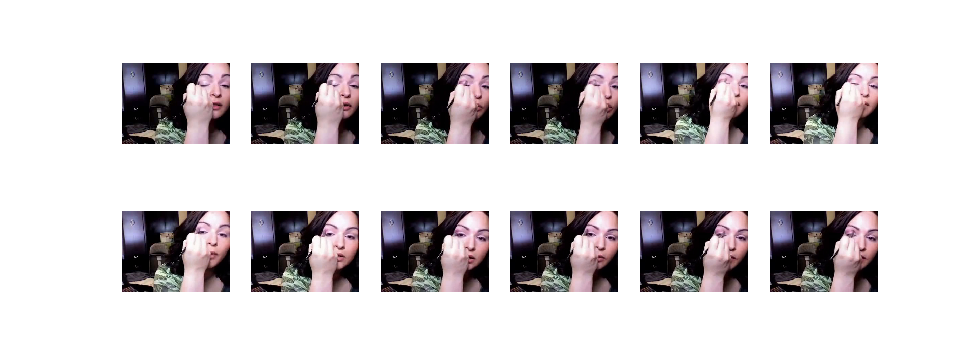

In [29]:
frames = []
for i in range(len(frames_idx)):
    f = vid.get_data(frames_idx[i])
    rf = cv2.resize(f, (const.nominal_width, const.nominal_height))
    frames.append(rf)
    
matplotlib.pyplot.figure()

for i in range(len(frames)):
    matplotlib.pyplot.subplot(2, n_frames / 2, i+1)
    matplotlib.pyplot.axis('off')
    matplotlib.pyplot.imshow(frames[i])

## Build Stack of Difference

In [32]:
sod = np.stack(frames, 3)
print(sod.shape)

(240, 320, 3, 12)


## Pickle

In [33]:
utils.pkl_write('sample.pkl', sod)